In [1]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");


v3.0
v4.0


In [2]:
## outer 6 
function ff_out_7(F,u,p; atol = 1e-12)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = p
        global ρ,ρa,m,ep
        local c
        ρ  = u[(0*Nx+1):1:(1*Nx)]
        ρa = u[(1*Nx+1):1:(2*Nx)]
        c  = u[end]

        for i in 2:(ind-1)
            F[i-1]      = rho_out_eq_2(ρ,ρa,c,i; p = p) - rho_out_eq_2(ρ,ρa,c,1; p = p)
            F[Nx-3+i]   = act_out_eq_2(ρ,ρa,c,i; p = p) - act_out_eq_2(ρ,ρa,c,1; p = p)
        end

        for i in (ind+1):1:(Nx-1)
            F[i-1]      = rho_out_eq_2(ρ,ρa,c,i; p = p) - rho_out_eq_2(ρ,ρa,c,1; p = p)
            F[Nx-3+i]   = act_out_eq_2(ρ,ρa,c,i; p = p) - act_out_eq_2(ρ,ρa,c,1; p = p)
        end

        ind1 = 1
        γ_end = (-ρa[end].+1)./(-ρ[end].+1)
        γ_srt = (-ρa[ind1].+1)./(-ρ[ind1].+1)
        F[ind-1]    = gg0.(ρ[end], γ_end; Pe = v0) - gg0.(ρ[ind1], γ_srt; Pe = v0)
        F[Nx-3+ind] = (hhh0.(ρ[end], γ_end; Pe = v0, atol = atol) - hhh0.(ρ[ind1], γ_srt; Pe = v0, atol = atol))./10
        F[2*Nx+1]   = γ_end .- γ_srt

        ind1 = ind +1 
        F[2*Nx-3] = ρa[ind] - ϕaL
        F[2*Nx-2] = ρa[ind1] - ϕaR
        F[2*Nx-1] = ρ[ind] - ϕL
        F[2*Nx]   = ρ[ind1] - ϕR 
end

function load_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    filename = outer_save_name_7(param,ind,γ)
    data = load(filename)
    @unpack f, c = data
    u = get_out_u(f,c,Lx)
    return f, u, c
end

using NonlinearSolve, DifferentialEquations
function solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u0; tol = 1e-8, maxiters = 100)
    param, p = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    # Set problem
    prob = NonlinearProblem(ff_out_7,u0, p; abstol = tol, reltol =  tol, maxiters = maxiters);
    sol  = solve(prob)
    #
    # Save
        u = sol.u
        f = get_out_f(u,param)
        c = u[end]/Lx
        filename    = outer_save_name_7(param,ind,γ)
        data        = Dict("f" => f, "c" => c)
        safesave(filename,data)
    #
    return f, u, c
end

function get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    param = get_stretch_param(Lx)
    name = "outer_sol_7"
    Δx = Lx/Nx
    DT = DR = 1.0
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0;initial_Δ = 1e-6, tol = 1e-8 )
    @pack! param = Lx,Nx,ϕa,ϕp,v0,name,Δx
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR
    return param, ps
end

function outer_save_name_7(param,ind,γ)
    @unpack DT, v0, DR, Nx, Lx, name, ϕa, ϕp = param
    return "/store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/outer_sol/$(name)/[DT,v0,DR,Nx,ind,γ]=$([DT,v0,DR,Nx,ind,γ]).jld2"
end

function check_u_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    param, _ = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    F = zeros(2*Nx+1)
    ff_out_7(F,u,ps)
    f = get_out_f(u,param)
    avmag = Lx*sum(f[:,2]-f[:,1])/Nx
    return maximum(abs.(F)), argmax(abs.(F)), avmag, u[end]/Lx
end

function increase_ind_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    i = ind
    u[i+1] = u[i]
    i = Nx + i 
    u[i+1] = u[i]
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, (ind+1), γ, ϕaL, ϕaR, ϕL, ϕR
    return u, ps
end

function decrease_ind_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    i = ind
    u[i] = u[i+1]
    i = Nx + i
    u[i] = u[i+1]
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, (ind-1), γ, ϕaL, ϕaR, ϕL, ϕR
    return u, ps
end

function increase_inds(u,ps,n)
    for i in 1:n
        u, ps = increase_ind_7(u,ps)
    end
    return u, ps
end

function decrease_inds(u,ps,n)
    for i in 1:n
        u, ps = decrease_ind_7(u,ps)
    end
    return u, ps
end
# 

decrease_inds (generic function with 1 method)

In [53]:
Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 56, 2.03
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 800, 1.5
param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = load_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# f,u,c = solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 10)
# check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        if ϕp ≈ ( param["ϕp"] )
            ϕp = param["ϕp"]
        else
            ϕp = d2(ϕp)
        end
        ϕa = sum(f[:,1:2])/Nx
        if ϕa ≈ ( param["ϕa"] )
            ϕa = param["ϕa"]
        else
            ϕa = d2(ϕa)
        end
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_7(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")

ϕa,ϕp=(0.81,0.1): rhodiff=0.14906585983537624, c =0.014917646711915977, avmag=0.2164818129504669, err=2.333688797762079e-13,1023, ind=56


In [54]:
ρ  = u[(0*Nx+1):1:(1*Nx)]
ρa  = u[(1*Nx+1):1:(2*Nx)]
γ_end = (-ρa[end].+1)./(-ρ[end].+1)

1.7369414724789993

In [46]:
Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 1000, 1.4
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 56, 1.7369414724789993
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 208, 1.71
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 200, 1.7
param, ps = get_outer_param_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = load_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# f,u,c = solve_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters =10)
# check densities
    ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
    ϕa = sum(f[:,1:2])/Nx
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_6(u,ps);
println("ϕa,ϕp=($(d4(ϕa)),$(d4(ϕp))): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")

ϕa,ϕp=(0.3124,0.2231): rhodiff=0.35385821948371854, c =0.0022279445854597566, avmag=0.2868911603228016, err=2.4227092554340857e-11,991, ind=1000


In [32]:
# for i in 1:7
    # global u, ps, f,c, DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR
    u,ps = increase_inds(u,ps,1)
    DT, v0, DR, Δx, Nx, Lx, ϕa,ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    # γ = 1.8
    # ind = 701
    f,u,c = solve_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 20)
    # check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        ϕa = sum(f[:,1:2])/Nx
    #
    param, ps = get_outer_param_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    err, erri, avmag, cep = check_u_6(u,ps);
    rhodiff = u[ind+1] - u[ind]
    println("ϕa,ϕp=($(d4(ϕa)),$(d4(ϕp))): rhodiff=$(rhodiff), cep =$(cep), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")
# end

ϕa,ϕp=(0.2519,0.1889): rhodiff=-1.4432899320127035e-15, cep =0.02124056431299977, avmag=0.3277575015173716, err=0.006929378305753797,1007, ind=1009


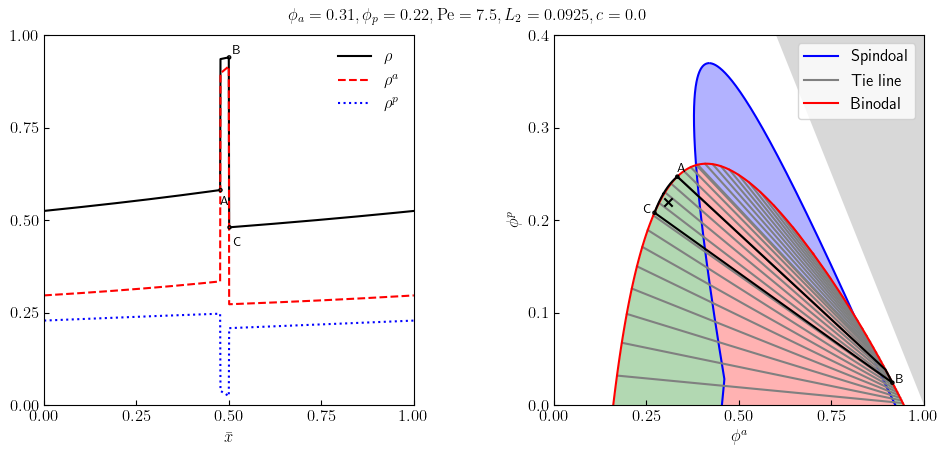

In [47]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f; c=c, point = ind-Nx÷2)